# Cement Plant Capacity Estimation

## Overview

If the cement industry were a country, it would be the third largest emitter in the world - it is the source of about 8% of the world's carbon dioxide (CO2) emissions, according to think tank Chatham House. China currently produces over half of the world’s cement - an estimated 2.2 billion metric tons in 2019. Global cement production is expected to increase to 4.83 billion metric tons in 2030.

![Cement Production](https://ichef.bbci.co.uk/news/976/cpsprodpb/1313C/production/_104804187_biggest_cement_producers_976px_v3-nc.png)

CO2 emissions highly dependent on proportion of clinker used in each tonne of cement - energy efficiency / technology of clinker production are key factors affecting site-specific carbon footprint. 

![Why Clinker is Bad](https://ichef.bbci.co.uk/news/976/cpsprodpb/23B4/production/_104804190_why_clinker_is_bad_976px_v3-nc.png)

Development of a global catalogue of cement factories and their capabilities can dramatically enhance the ability of investors, regulators, governments, and civil society to measure and manage different forms of environmental risk, opportunity, and impact. Production capacity - measured in units of megatons per year - is a key attribute closely linked with site-specific CO2 footprint.

## Objective


## Datasets


In [2]:
import os

# authentication key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='C:/Users/Chris.Williams/.gcs/arkham-255409-c59a52d8653f.json'

In [2]:
from google.cloud import storage
from io import BytesIO

# download pretrained model from google cloud
client = storage.Client()
bucket = client.get_bucket('eo-ald-update')

# construct remote path
repo = 'ald'
filenames = [ 'models/vgg16-256-128.zip', 'data/chips.zip' ]

# check files exist
for f in filenames:

    pathname = os.path.join( os.getcwd(), f )
    if not os.path.exists( pathname ):
                
        # make sub-directory if required
        if not os.path.exists ( os.path.dirname( pathname ) ):
            os.makedirs( os.path.dirname( pathname ) )

        # download blob
        remote_url = '{}/cement/capacity/{}'.format( repo, f )

        blob = storage.blob.Blob( remote_url, bucket)
        with open( pathname, 'w+b' ) as z:
            blob.download_to_file( z )


In [3]:
from zipfile import ZipFile

# extract downloaded zip files 
for f in filenames:
    pathname = os.path.join( os.getcwd(), f )
    with ZipFile( pathname, 'r') as zipObj:
       # extract contents to current directory
       zipObj.extractall( os.path.dirname( pathname ) )

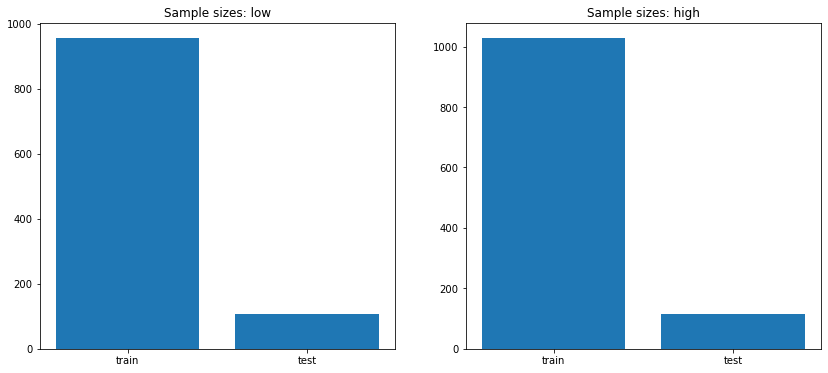

In [4]:
import matplotlib.pyplot as plt

# plot subset sample sizes for wet and dry classes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# get file list length - sample size
count = [None] * 2
for idx, s in enumerate( [ 'train', 'test' ] ):
    path = os.path.join( 'data/chips/', s )
    count[ idx ] = len( os.listdir( os.path.join( path, c ) ) )
                
# draw counts as subplot
axes.set_title( 'Sample sizes' )
axes.bar( [ 'train', 'test' ], count )


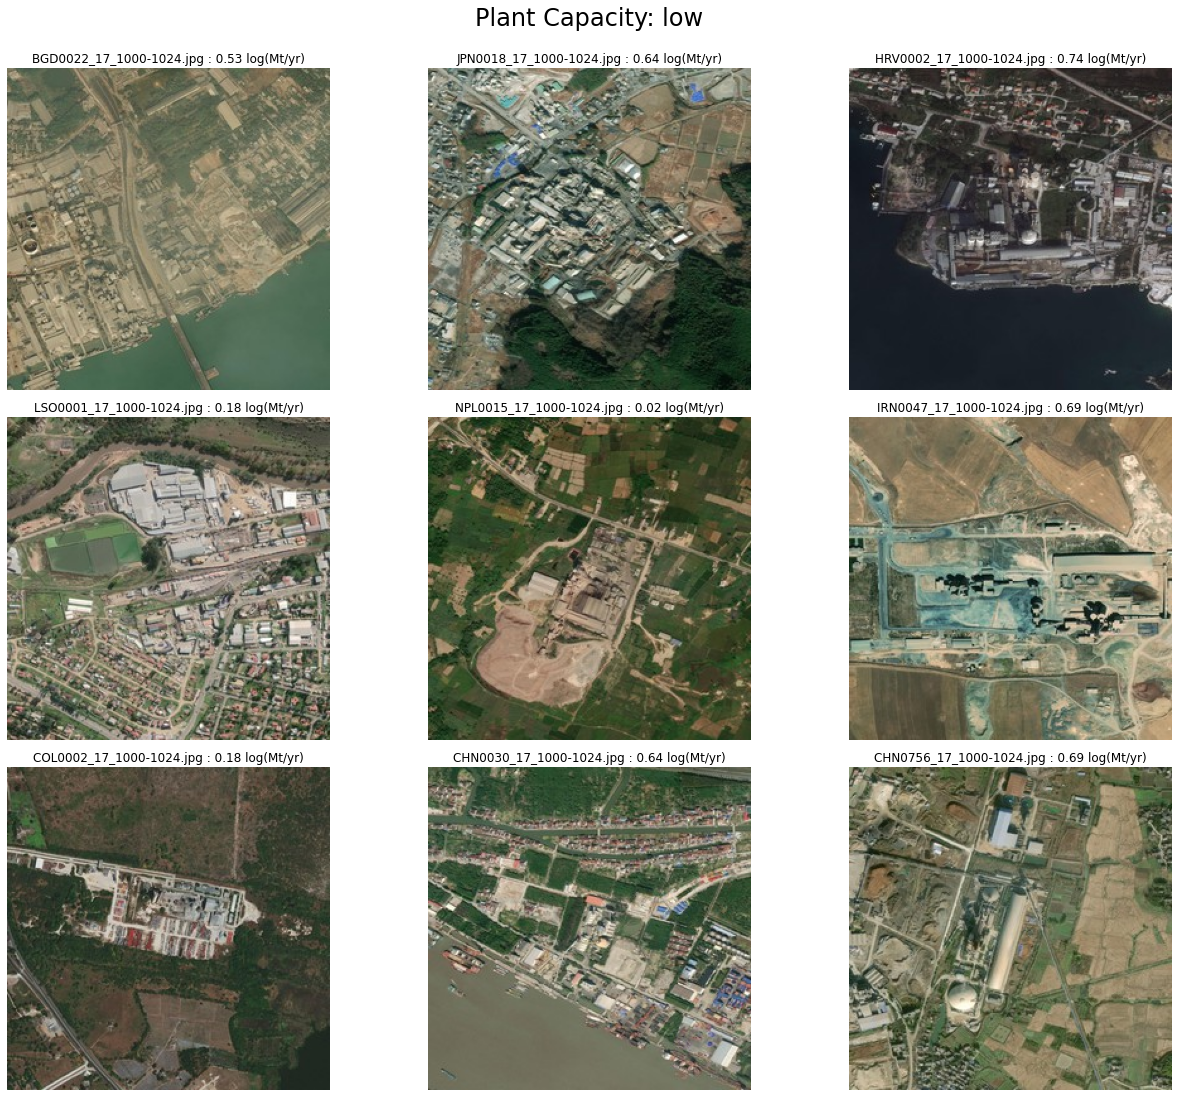

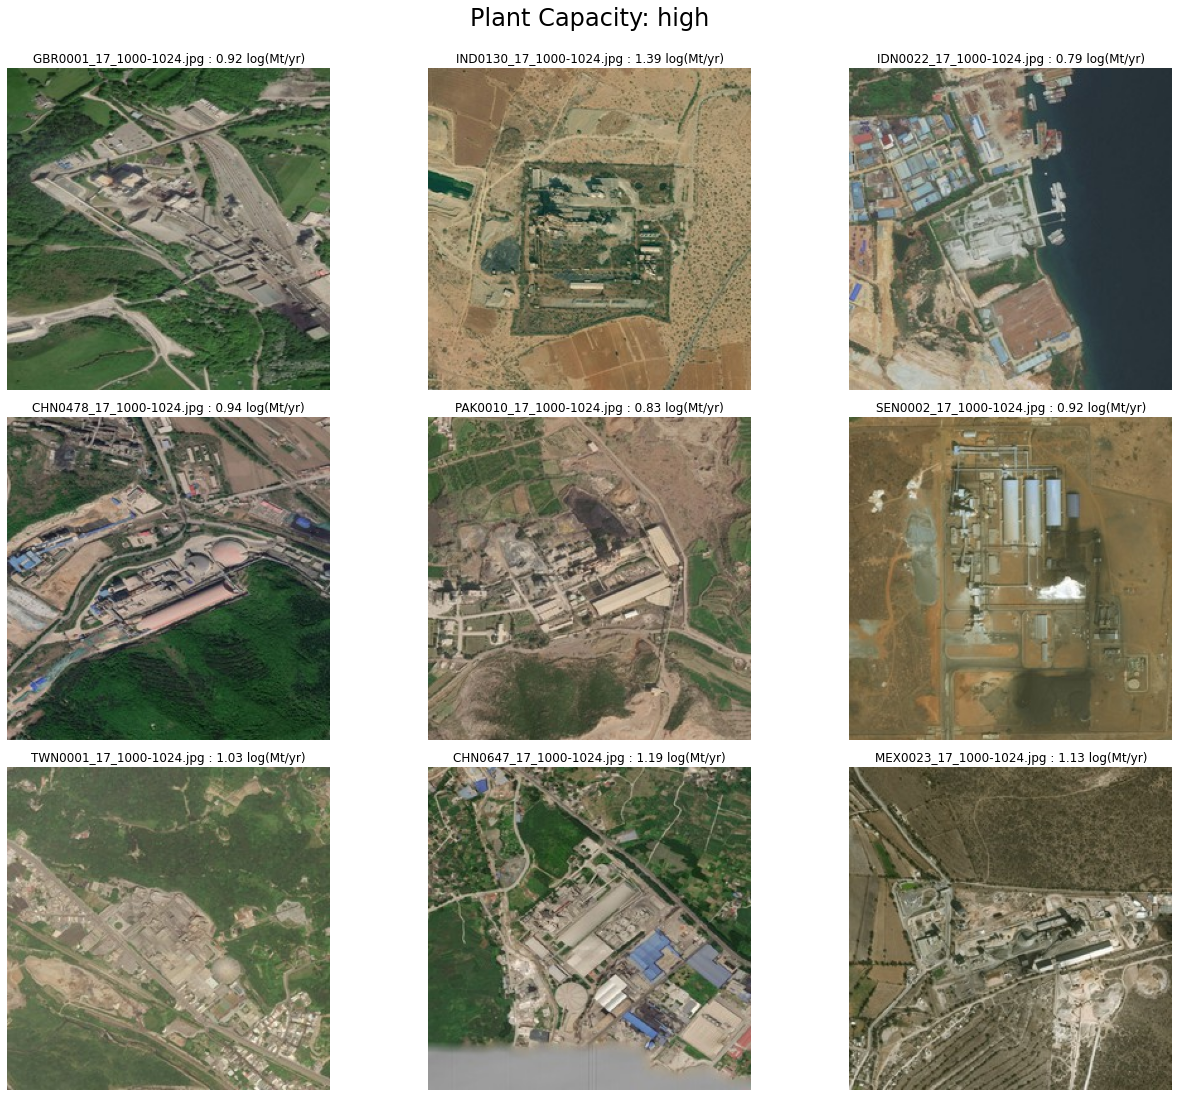

In [23]:
import random
import pandas as pd
from matplotlib.image import imread

df = pd.read_csv( os.path.join( 'data/chips/', 'test.csv'.format( c ) ) )
sample = df.sample(9) 
        
# create figure
fig = plt.figure( figsize=(18, 16) )    
fig.suptitle('Production Capacity', fontsize=24)

# randomly select entries from file list
count = 1
for idx, record in sample.iterrows():

    # define subplot
    ax = plt.subplot( 330 + count )
    ax.set_title( '{} : {:.2f} log(Mt/yr)'.format ( record[ 'image' ], record[ 'target' ] ) )
    plt.axis('off')

    # load and show image
    path = os.path.join( 'data/esri/test', c )
    image = imread( os.path.join( path, record[ 'image' ] ) )
    plt.imshow(image)

    count += 1

# tight layout with adjustment
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Model Architecture and Training

A pretrained VGG16 CNN model was selected as backbone for this analysis - output from CNN model was flattened and attached to two fully connected layers comprising 256 and 128 units respectively and assigned relu activation functions. The model was trained using an Adam optimiser - learning rate = 1e-6 - combined with mean absolute error loss function.



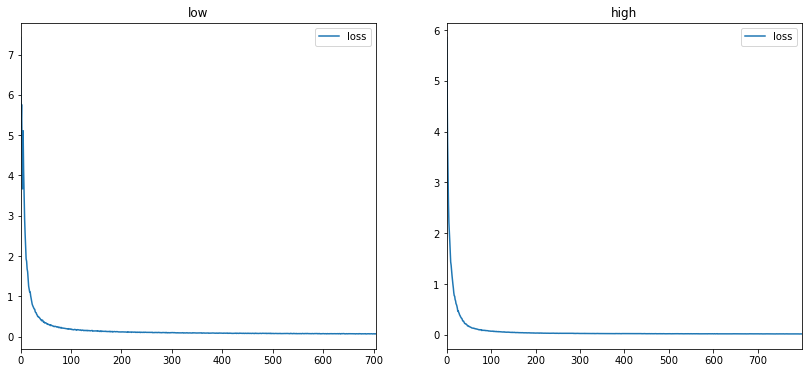

In [29]:
# plot diagnostic information
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

classes = [ 'low', 'high' ]
for idx, c in enumerate ( classes ):

    # load class-specific diagnostics from csv file
    path = os.path.join( os.getcwd(), 'models/esri/{}'.format( c ) )
    df=pd.read_csv( os.path.join( path, 'vgg16-256-128/log.csv') )
    
    # plot diagnostics of model 
    axes[idx].set_title( c )
    df.plot.line( ax=axes[idx], y=['loss'])


## Results


In [30]:
import tensorflow as tf

# initiate tensorflow session - allow access to all onboard CPU / GPU resources
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [38]:
from sklearn.preprocessing import MinMaxScaler

def getPrediction( datagen, model, c, subset ):

    # read dataframe and normalise target
    df = pd.read_csv( os.path.join( 'data/esri', '{}-{}.csv'.format( subset, c ) ) )

    scaler = MinMaxScaler()
    df[ 'target' ] = scaler.fit_transform( df[ [ 'target'] ] )

    # create iterator        
    data_path = os.path.join( os.path.join( 'data/esri', subset ), c )
    it = datagen.flow_from_dataframe(  dataframe=df,
                                        directory=data_path,
                                        x_col='image_name',
                                        y_col='target',
                                        class_mode='raw',
                                        color_mode='rgb',
                                        shuffle=False,
                                        target_size=(256,256),
                                        batch_size=1 )

    # run prediction
    df[ 'yhat' ] = model.predict_generator( it )
    return df


In [41]:
from scipy import stats
import matplotlib.pyplot as plt

def plotRegression( dfs ):
    
    # create figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for idx, df in enumerate( dfs ):

        # compute regression
        m, c, r2, p, err = stats.linregress( df['target'].values, df['yhat'].values )    

        # plot sample data and regression model
        axes[idx].plot( df['target'].values, df['yhat'].values, '.' )
        axes[idx].plot( [0, 1], [c, m+c], '-', label='y={:.2f}x+{:.2f}\nR2={:.2f}'.format( m, c, r2 ) )

        axes[idx].legend( fontsize=9 )
        
    plt.show()

    return


Loaded model from disk: models/esri/low\vgg16-256-128
Found 955 validated image filenames.
Found 107 validated image filenames.


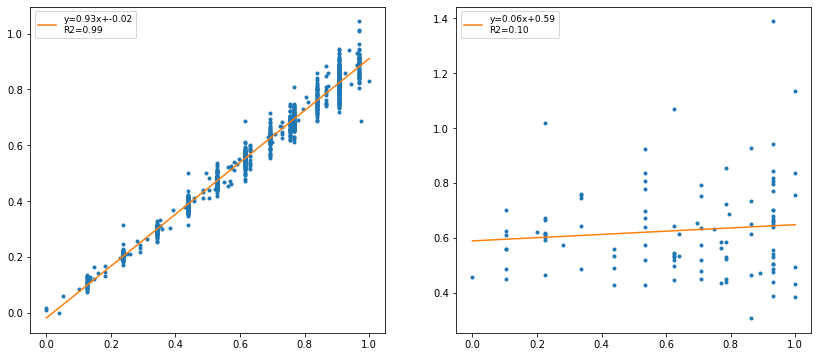

Loaded model from disk: models/esri/high\vgg16-256-128
Found 1028 validated image filenames.
Found 115 validated image filenames.


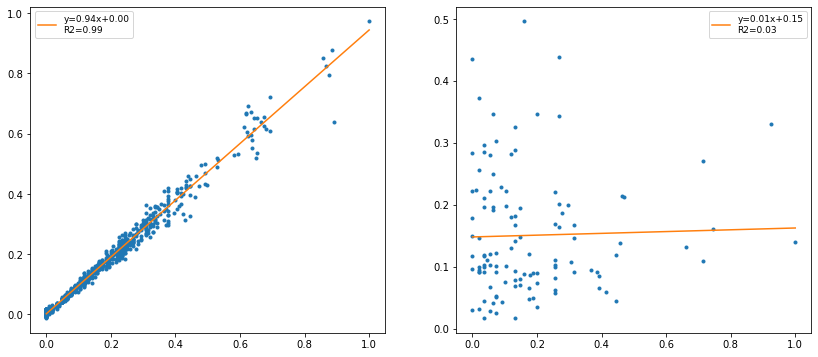

In [42]:
import importlib

from utility.dl.cnn import loadFromFile
from keras.preprocessing.image import ImageDataGenerator

# high low classes
for c in [ 'low', 'high']:

    # load pre-trained model from file 
    path = os.path.join( 'models/esri/', c )
    model, model_type = loadFromFile( os.path.join( path, 'vgg16-256-128' ) )

    # select preprocess_input wrapper
    module = importlib.import_module( 'keras.applications.{}'.format( model_type ) )
    preprocess_input = module.preprocess_input

    # create test generator
    datagen = ImageDataGenerator( preprocessing_function=preprocess_input )    
    
    # plot diagnostic information
    plotRegression( [ getPrediction( datagen, model, c, 'train' ), 
                   getPrediction( datagen, model, c, 'test' ) ] )
